This kernel presents how to build an ASE database from CHAMPS data and create a dataset, and then uses it for molecular property predictions.

First, please see an SchNet tutorial on QM9:

[SchNet QM9](https://www.kaggle.com/tonyyy/schnet-qm9)

which contains references of the SchNet architecture.

This kernel uses only potential energies and dipole moments in CHAMPS data. Mulliken charges and magnetic shielding tensors are used in the following kernels:
* [SchNet Mulliken Charges](https://www.kaggle.com/tonyyy/schnet-mulliken-charges)
* [SchNet Magnetic Shielding](https://www.kaggle.com/tonyyy/schnet-magnetic-shielding)

In [1]:
!ls ../../../data

dataframes			   split
dipole_moments.csv		   structures
external_data			   structures.csv
graphs				   structures.zip
magnetic_shielding_tensors.csv	   subs
mulliken_charges.csv		   test.csv
potential_energy.csv		   test_oof_fc.csv
sample_submission.csv		   train.csv
scalar_coupling_contributions.csv  train_oof_fc.csv


# CHAMPS data

In [2]:
import numpy as np
import pandas as pd

In [3]:
path='../../../data/'
molecules = pd.read_csv(path + 'structures.csv')
molecules = molecules.groupby('molecule_name')
energies = pd.read_csv(path + 'potential_energy.csv')
magnetic_shielding = pd.read_csv(path + 'magnetic_shielding_tensors.csv')
mulliken_charges = pd.read_csv(path + 'mulliken_charges.csv')
dipoles = pd.read_csv(path + 'dipole_moments.csv')

In [4]:
dipoles['scalar'] = np.sqrt(np.square(dipoles[['X', 'Y', 'Z']]).sum(axis=1))

The total number of molecules:

In [5]:
molecules.ngroups

130775

### Mulliken Charges

In [6]:
mulliken_charges.mulliken_charge.describe()

count    1.533537e+06
mean    -2.256222e-10
std      2.254392e-01
min     -7.334500e-01
25%     -1.915330e-01
50%      9.867800e-02
75%      1.273960e-01
max      7.289810e-01
Name: mulliken_charge, dtype: float64

In [7]:
mulliken_charges.mulliken_charge.hist(bins=50)

In [8]:
mulliken_charges = mulliken_charges.groupby('molecule_name')

In [9]:
mulliken_charges.get_group('dsgdb9nsd_000003')

,molecule_name,atom_index,mulliken_charge
9,dsgdb9nsd_000003,0,-0.589706
10,dsgdb9nsd_000003,1,0.294853
11,dsgdb9nsd_000003,2,0.294853


In [10]:
mulliken_charges.get_group('dsgdb9nsd_000003').mulliken_charge.sum()

0.0

### Magnetic Shielding Tensors

In [11]:
x = magnetic_shielding.columns.values[2:]
x = magnetic_shielding[x].values
x = x.reshape(-1,3,3)
x = x + np.transpose(x,(0,2,1))
x = 0.5 * x
w, v = np.linalg.eigh(x)

In [12]:
sigma_iso = np.sum(w, axis=1)/3 

In [13]:
omega = w[:,2] - w[:,0]

In [14]:
kappa = 3 * (sigma_iso - w[:,1])/omega

In [15]:
magnetic_shielding_parameters = magnetic_shielding[magnetic_shielding.columns.values[:2]]
magnetic_shielding_parameters = pd.DataFrame(magnetic_shielding_parameters)
magnetic_shielding_parameters["sigma_iso"] = sigma_iso
magnetic_shielding_parameters["omega"] = omega
magnetic_shielding_parameters["kappa"] = kappa

magnetic_shielding_parameters.head()

,molecule_name,atom_index,sigma_iso,omega,kappa
0,dsgdb9nsd_000001,0,195.316333,0.002708,0.032697
1,dsgdb9nsd_000001,1,31.460567,9.082838,0.999975
2,dsgdb9nsd_000001,2,31.460567,9.082793,0.999984
3,dsgdb9nsd_000001,3,31.460633,9.082804,0.999977
4,dsgdb9nsd_000001,4,31.460600,9.082853,0.999971


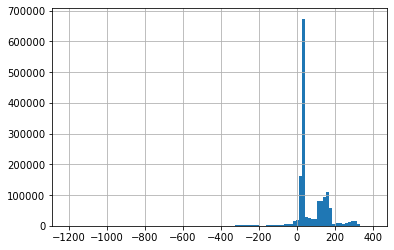

In [16]:
_ = magnetic_shielding_parameters.sigma_iso.hist(bins=100)

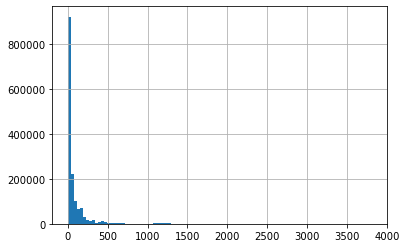

In [17]:
_ = magnetic_shielding_parameters.omega.hist(bins=100)

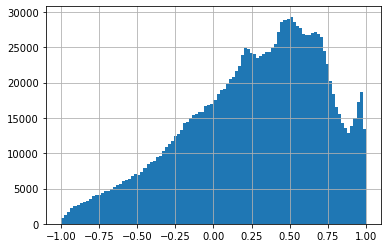

In [18]:
_ = magnetic_shielding_parameters.kappa.hist(bins=100)

In [19]:
msp = magnetic_shielding_parameters.groupby('molecule_name')

### Potential Energy

In [20]:
energies.head()

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.52368
1,dsgdb9nsd_000002,-56.56025
2,dsgdb9nsd_000003,-76.42608
3,dsgdb9nsd_000005,-93.42849
4,dsgdb9nsd_000007,-79.83869


In [21]:
len(energies)

85003

In [22]:
energy_series = pd.Series(energies.set_index('molecule_name')['potential_energy'])
energy_series.describe()

count    85003.000000
mean      -410.874055
std         39.828871
min       -714.626200
25%       -438.000750
50%       -416.921700
75%       -387.218950
max        -40.523680
Name: potential_energy, dtype: float64

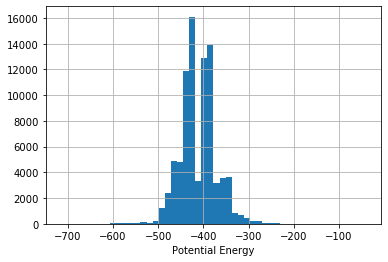

In [23]:
ax = energy_series.hist(bins=50)
_ = ax.set_xlabel("Potential Energy")

### Dipole Moment

In [24]:
dipoles.head()

,molecule_name,X,Y,Z,scalar
0,dsgdb9nsd_000001,0.0000,0.0,0.0000,0.0000
1,dsgdb9nsd_000002,-0.0002,0.0,1.6256,1.6256
2,dsgdb9nsd_000003,0.0000,0.0,-1.8511,1.8511
3,dsgdb9nsd_000005,0.0000,0.0,-2.8937,2.8937
4,dsgdb9nsd_000007,0.0000,0.0,0.0000,0.0000


In [25]:
len(dipoles)

85003

In [26]:
dipole_series = pd.Series(dipoles.set_index('molecule_name')['scalar'])
dipole_series.describe()

count    85003.000000
mean         2.672361
std          1.492801
min          0.000000
25%          1.581295
50%          2.474998
75%          3.600646
max         22.960504
Name: scalar, dtype: float64

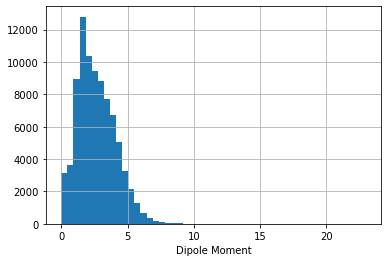

In [27]:
ax = dipole_series.hist(bins=50)
_ = ax.set_xlabel("Dipole Moment")

# ASE Database

A dataset object used in SchNetPack is built on an ASE database. Please see the document of the ASE database:

https://wiki.fysik.dtu.dk/ase/ase/db/db.html

In [28]:
train = pd.read_csv(path + 'train.csv')
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [29]:
test = pd.read_csv(path + 'test.csv')
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [30]:
train_molecule_names = train.molecule_name.unique()
len_train = len(train_molecule_names)
len_train

85003

In [31]:
test_molecule_names = test.molecule_name.unique()
len(test_molecule_names)

45772

In [32]:
train_test = train.append(test, sort=False)
len(train_test)

7163689

In [33]:
train_test_molecule_names = train_test.molecule_name.unique()
len(train_test_molecule_names), len_train + len(test_molecule_names)

(130775, 130775)

In [34]:
from ase import Atoms
from ase.db import connect

def create_db(db_path, molecule_names):
    with connect(db_path) as db:
        for name in molecule_names:
            mol = molecules.get_group(name)
            atoms = Atoms(symbols=mol.atom.values,
                          positions=[(row.x,row.y,row.z) for row in mol.itertuples()])
            try:
                mol_msp = msp.get_group(name)
                sigma_iso = mol_msp['sigma_iso'].values.reshape(-1,1)
                omega = mol_msp['omega'].values.reshape(-1,1)
                kappa = mol_msp['kappa'].values.reshape(-1,1)
            except KeyError:
                sigma_iso, omega, kappa = [None] * 3
                
            try:
                charges = mulliken_charges.get_group(name).mulliken_charge.values.reshape(-1,1)
                total_charge = 0.0
            except KeyError:
                charges = None
                total_charge = None
                
            db.write(atoms, name=name,
                     potential_energy=energy_series.get(name, default=float('nan')),
                     scalar_dipole=dipole_series.get(name, default=float('nan')),
                     data=dict(sigma_iso=sigma_iso, omega=omega, kappa=kappa, 
                               charges=charges, total_charge=total_charge))

In [35]:
champs_path = '/home/christian/test/CHAMPS.db' 
dataset_size = len(train_test_molecule_names) # 20000
dataset_molecule_names = train_test_molecule_names[:dataset_size]

In [36]:
#create_db(db_path=champs_path, molecule_names=dataset_molecule_names)

In [37]:
with connect(champs_path) as db:
    print(len(db))

130775


In [38]:
import schnetpack

properties=['potential_energy', 'scalar_dipole', 'sigma_iso', 'omega', 'kappa', 'charges', 'total_charge']

dataset = schnetpack.data.AtomsData(champs_path, properties=properties)

In [39]:
print(len(dataset), dataset.properties)

130775 ['potential_energy', 'scalar_dipole', 'sigma_iso', 'omega', 'kappa', 'charges', 'total_charge']


# SchNet Model

Please see the SchNetPack API document:

https://schnetpack.readthedocs.io/en/stable/modules/index.html

In [40]:
import pandas as pd

import torch
import torch.nn.functional as F
from torch.optim import Adam

import schnetpack as spk
import schnetpack.atomistic as atm
import schnetpack.representation as rep
from schnetpack.datasets import *

device = torch.device("cuda")

In [41]:
# This function comes from the following script:
# https://github.com/atomistic-machine-learning/schnetpack/blob/v0.2.1/src/scripts/schnetpack_qm9.py
def evaluate_dataset(metrics, model, loader, device):
    for metric in metrics:
        metric.reset()

    with torch.no_grad():
        for batch in loader:
            batch = {
                k: v.to(device)
                for k, v in batch.items()
            }
            result = model(batch)

            for metric in metrics:
                metric.add_batch(batch, result)

    results = [
        metric.aggregate() for metric in metrics
    ]
    return results

In [42]:
from schnetpack.data import Structure

class Mulliken(atm.Atomwise):
    def __init__(self):
        super(Mulliken, self).__init__(return_contributions=True)
        
    def forward(self, inputs):
        result = super().forward(inputs)
        
        atom_mask = inputs[Structure.atom_mask].byte()
        
        yi = inputs['charges']
        yi = torch.masked_select(yi.squeeze(dim=2), atom_mask)
        inputs['mulliken_true'] = yi
        
        yi = result['yi']
        yi = torch.masked_select(yi.squeeze(dim=2), atom_mask)
        result['mulliken_pred'] = yi
        
        return result

In [50]:
from schnetpack.data import Structure

class MagneticShielding(atm.Atomwise):
    def __init__(self):
        super(MagneticShielding, self).__init__(return_contributions=True)
        
    def forward(self, inputs):
        result = super().forward(inputs)
        
        atom_mask = inputs[Structure.atom_mask].byte()
        for property in ['sigma_iso', 'omega', 'kappa']:
            yi = inputs[property]
            yi = torch.masked_select(yi.squeeze(dim=2), atom_mask)
            inputs[property+'_true'] = yi
        
            yi = result['yi']
            yi = torch.masked_select(yi.squeeze(dim=2), atom_mask)
            result[property+'_pred'] = yi
        
        return result

In [51]:
def schnet_model():
    reps = rep.SchNet(n_interactions=6)
    output = [atm.Atomwise(), atm.DipoleMoment(n_in=128, predict_magnitude=True), Mulliken(), MagneticShielding()]
    model = atm.AtomisticModel(reps, output)
    model = model.to(device)
    
    return model

In [52]:
def train_model(max_epochs=500):
    # split in train and val
    #n_dataset = len(dataset)
    n_val = len_train//10 #n_dataset // 10
    train_data, val_data, test_data = dataset.create_splits(len_train-n_val, n_val)
    train_loader = spk.data.AtomsLoader(train_data, batch_size=128, num_workers=2)
    val_loader = spk.data.AtomsLoader(val_data, batch_size=256, num_workers=2)

    # create model
    model = schnet_model()

    # create trainer
    opt = Adam(model.parameters(), lr=2e-4, weight_decay=1e-6)
    
    loss = lambda b, p: F.mse_loss(p["y"], b["potential_energy"])
    metrics = [
        spk.metrics.MeanAbsoluteError("potential_energy", "y"),
        spk.metrics.RootMeanSquaredError("potential_energy", "y"),
    ]
    hooks = [
        spk.train.MaxEpochHook(max_epochs),
        spk.train.CSVHook('/home/christian/test/log', metrics, every_n_epochs=1),
    ]
    trainer = spk.train.Trainer('/home/christian/test/output', model, loss,
                            opt, train_loader, val_loader, hooks=hooks)

    # start training
    trainer.train(device)
    
    # evaluation
    model.load_state_dict(torch.load('/home/christian/test/output/best_model'))
    test_loader = spk.data.AtomsLoader(test_data, batch_size=256, num_workers=2)
    model.eval()

    df = pd.DataFrame()
    df['metric'] = ['MAE', 'RMSE']
    df['training'] = evaluate_dataset(metrics, model, train_loader, device)
    df['validation'] = evaluate_dataset(metrics, model, val_loader, device)
    df['test'] = evaluate_dataset(metrics, model, test_loader, device)
    display(df)
    
    return test_data

In [53]:
def show_history():
    df = pd.read_csv('/home/christian/test/log/log.csv')
    display(df.tail())
    max_value = None # df['RMSE_'+property].min()*5
    _ = df[['MAE_potential_energy','RMSE_potential_energy']].plot(ylim=(0,max_value))

In [54]:
def test_prediction(dataset):
    # create model
    model = schnet_model()
    
    # load the best parameters
    model.load_state_dict(torch.load('/home/christian/test/best_model'))
    loader = spk.data.AtomsLoader(dataset, batch_size=256, num_workers=2)
    model.eval()
    
    # predict molecular properties
    targets = []
    predictions = []
    with torch.no_grad():
        for batch in loader:
            batch = {
                k: v.to(device)
                for k, v in batch.items()
            }
            result = model(batch)
            targets += batch.squeeze().tolist()
            predictions += result['y'].squeeze().tolist()
    return targets, predictions

In [55]:
def show_predictions(dataset):
    targets, predictions = test_prediction(dataset)
    df_pred = pd.DataFrame()
    df_pred['Target'] = targets
    df_pred['Prediction'] = predictions
    df_pred.plot.scatter(x='Target', y='Prediction', title='predictions')

# Results

In [57]:
used_test_data = train_model(max_epochs=1)

,Time,Learning rate,Train loss,Validation loss,MAE_potential_energy,RMSE_potential_energy
0,1.563429e+09,0.0002,2.144590e+06,15.976641,2.649294,3.997079
1,1.563429e+09,0.0002,2.161852e+06,68.833728,5.877186,8.296609


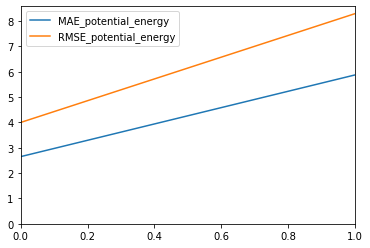

In [29]:
show_history()

In [30]:
len(used_test_data)

8500

In [31]:
used_test_data.head()

AttributeError: 'AtomsData' object has no attribute 'head'

In [ ]:
show_predictions(used_test_data)

In [29]:
!mv potential_energy/log/log.csv log_potential.csv
!mv scalar_dipole/log/log.csv log_dipole.csv
!mv potential_energy/output/best_model best_model_potential
!mv scalar_dipole/output/best_model best_model_dipole
!rm -r potential_energy
!rm -r scalar_dipole